<img src="Logo_RappiCard_2021_Black.jpg" alt="PROYECTO TÉCNICO RAPPICARD - DS" width="400"/>

### Proyecto Técnico RappiCard - DS

Dentro del siguiente Notebook se presenta un modelo capaz de detectar defraudadores.


# 1. Cargar los datos y librerías necesarias

In [1]:
# Cargamos librerías

import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Import data from CSV
import os
os.chdir("/Users/AlbertoMorales/Documents/Ficheros_Rappi")

from datetime import datetime

In [3]:
## Cargar el dataset 
data=pd.read_csv("Reto_DS/ds_challenge_data_2024_JR.csv")

In [4]:
## visualizamos los primeros registros
data.head(6)

,transaction_id,user_id,género,linea_tc,interes_tc,monto,fecha,hora,dispositivo,establecimiento,ciudad,status_txn,is_prime,dcto,cashback,fraude
0,1,573,M,87000,56,581.03,02/01/20,0,"{'año': 2019, 'marca': 'Apple', 'proveedor': '...",Farmacia,Ciudad de México,Aceptada,False,0.0,17.43,False
1,2,737,F,34000,51,421.73,02/01/20,0,"{'año': 2021, 'marca': 'Huawei', 'proveedor': ...",Tienda departamental,Cancún,Aceptada,False,0.0,12.65,False
2,3,887,F,52000,38,399.55,02/01/20,0,"{'año': 2017, 'marca': 'Apple', 'proveedor': '...",Farmacia,Tijuana,En proceso,False,0.0,11.99,False
3,4,1304,M,67000,60,828.01,02/01/20,0,"{'año': 2019, 'marca': 'Samsung', 'proveedor':...",Tienda departamental,Ciudad de México,En proceso,False,0.0,24.84,False
4,5,1361,F,28000,52,886.04,02/01/20,0,"{'año': 2021, 'marca': 'Samsung', 'proveedor':...",Supermercado,Cancún,Aceptada,False,0.0,26.58,False
5,6,1894,M,72000,53,736.88,02/01/20,0,"{'año': 2020, 'marca': 'Motorola', 'proveedor'...",Farmacia,Ciudad de México,En proceso,False,0.0,22.11,False


In [5]:
# Mostrar los campos y tipo de dato que contiene nuestro dataset
data.describe(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26975 entries, 0 to 26974
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   transaction_id   26975 non-null  int64  
 1   user_id          26975 non-null  int64  
 2   género           26975 non-null  object 
 3   linea_tc         26975 non-null  int64  
 4   interes_tc       26975 non-null  int64  
 5   monto            26975 non-null  float64
 6   fecha            26975 non-null  object 
 7   hora             26975 non-null  int64  
 8   dispositivo      26975 non-null  object 
 9   establecimiento  24036 non-null  object 
 10  ciudad           26641 non-null  object 
 11  status_txn       26975 non-null  object 
 12  is_prime         26975 non-null  bool   
 13  dcto             26975 non-null  float64
 14  cashback         26975 non-null  float64
 15  fraude           26975 non-null  bool   
dtypes: bool(2), float64(3), int64(5), object(6)
memory usage: 

(       transaction_id       user_id      linea_tc    interes_tc         monto  \
 count    26975.000000  26975.000000  26975.000000  26975.000000  26975.000000   
 mean     13488.000000   2003.765412  62476.811863     48.224875    513.796463   
 std       7787.156092   1144.630736  21886.892902      9.587256    290.342419   
 min          1.000000      0.000000  25000.000000     32.000000      1.000000   
 25%       6744.500000   1041.000000  44000.000000     40.000000    300.490000   
 50%      13488.000000   2006.000000  62000.000000     48.000000    506.380000   
 75%      20231.500000   2973.500000  82000.000000     57.000000    716.515000   
 max      26975.000000   3999.000000  99000.000000     64.000000   1712.700000   
 
                hora          dcto      cashback  
 count  26975.000000  26975.000000  26975.000000  
 mean      12.657498      5.369477     16.924524  
 std        5.657335     12.322335     10.893845  
 min        0.000000      0.000000      0.030000  
 25% 

#### Descripción de los campos que contiene nuestro Dataset


**transaction_id**: ID de la transacción.

**user_id**: ID del usuario.

**linea_tc**: Límite de crédito.

**interes_tc**: Tasa de interés.

**monto**: Monto de la transacción.

**fecha**: Fecha en que se realizó la transacción.

**hora**: Hora de la transacción.

**establecimiento**: Tipo de establecimiento donde se realizó la transacción.

**ciudad**: Ciudad donde se realizó la transacción.

**status_txn**: Estado de la transacción.

**is_prime**: Indica si el usuario "Prime" (1 = sí, 0 = no).

**dcto**: Descuento aplicado.

**cashback**: Cashback generado.

**fraude**: nuestra variable objetivo, la cual nos indica si es Fraudulento o no.


Nos damos cuenta que el Dataset cuenta con 2,6975 registros con un total de 16 columanas con tipo de dato categoricos, numericos y booleano, a primera vista vemos que dos de nuestras columnas tiene varios nulos, y observamos los principales datos estadisticos para darnos cuenta de lo que contiene nuestro Dataset.

# 2. Indagamos un poco nuestro Dataset

La idea de este punto es análizar un poco la información para saber prepar nuestros datos en un siguiente paso.

In [6]:
# revisamos si tenemos valores nulos
data.isna().sum()

transaction_id        0
user_id               0
género                0
linea_tc              0
interes_tc            0
monto                 0
fecha                 0
hora                  0
dispositivo           0
establecimiento    2939
ciudad              334
status_txn            0
is_prime              0
dcto                  0
cashback              0
fraude                0
dtype: int64

In [7]:
# Observamos que nuestro Dataset esta bastante desbalanceado
cuenta_fraude = data['fraude'].value_counts()
cuenta_fraude

False    26165
True       810
Name: fraude, dtype: int64

In [8]:
# Observamos que nuestro Dataset esta bastante desbalanceado
avg_fraude = data['fraude'].value_counts(normalize=True) * 100
avg_fraude

False    96.99722
True      3.00278
Name: fraude, dtype: float64

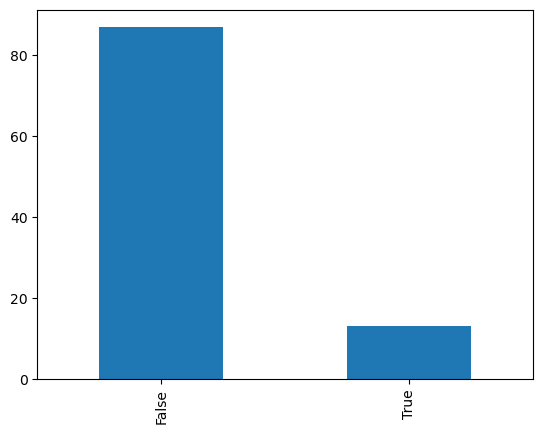

In [9]:
# revisamos si será relevante PRIME
cuenta_prime = data['is_prime'].value_counts(normalize=True) * 100
cuenta_prime
# gráfica de barras
cuenta_prime.plot.bar();

In [10]:
# Revisamos como se muestra el Género
cuenta_genero = data['género'].value_counts()
cuenta_genero

M    12472
F    12000
N     2503
Name: género, dtype: int64

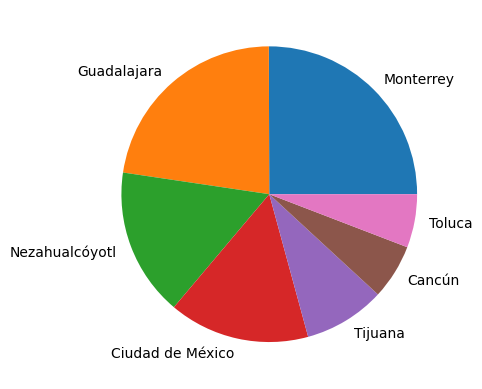

In [11]:
# Distribución de la ciudad 
cuenta_ciudad = data['ciudad'].value_counts(normalize=True) * 100
plt.pie(cuenta_ciudad, labels=cuenta_ciudad.index)
plt.show();

In [12]:
# Correlación ( solo es un ejercicio con 3 variables)
matrix_corr = data[['monto', 'cashback', 'interes_tc']].corr()
matrix_corr

,monto,cashback,interes_tc
monto,1.000000,0.877533,0.008421
cashback,0.877533,1.000000,0.011794
interes_tc,0.008421,0.011794,1.000000


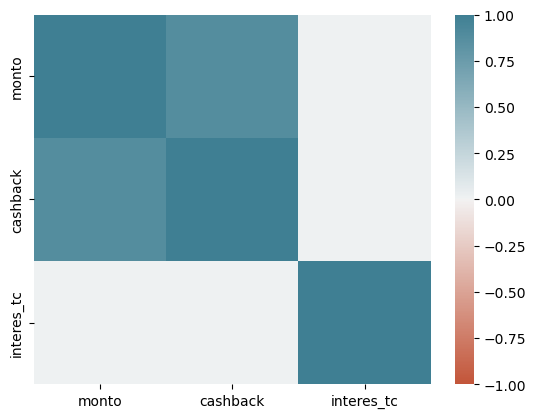

In [13]:
# hacemos un plot de la correlación de nuestros campos
import seaborn as sns
sns.heatmap(matrix_corr, vmin=-1, vmax=1,
           cmap=sns.diverging_palette(20,220, as_cmap=True));

In [14]:
# exploramos cuantos muestras y atributos tenemos
print(f'Tenemos {data.shape[0]} muestras y {data.shape[1]-1} atributos')

Tenemos 26975 muestras y 15 atributos


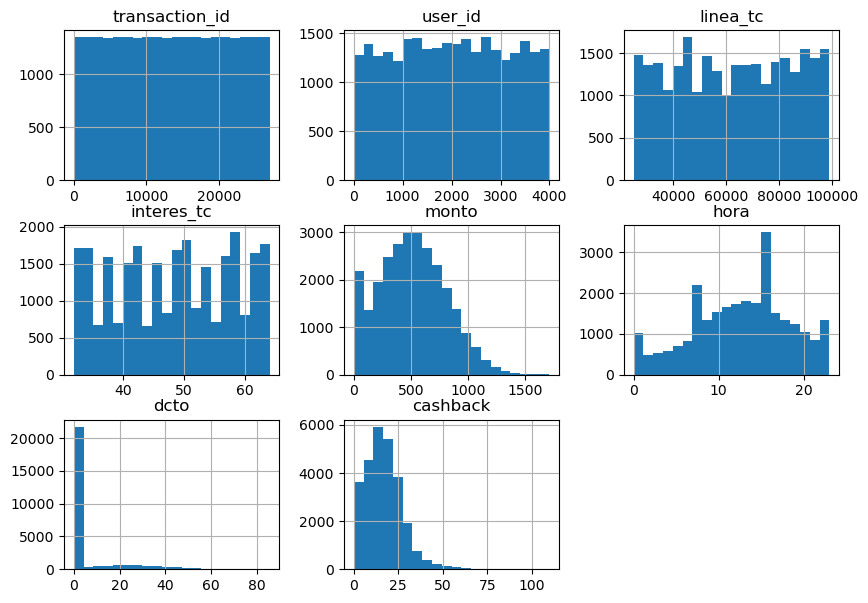

In [15]:
# seguimos explorando las variables con un histograma
data.hist(bins=20, figsize=(10,7))
plt.show()

**Nota** Esta eploración de los datos ayuda a entender mejor como vamos a procesar los dato y nos damos una idea de la consistencia de nuestra variable objetivo.

# 2. Preprocesamiento y Limpieza de Datos

En esta parte limpiaremos y preprocesaremos los datos, lo cual incluye manejar valores faltantes, codificar variables categóricas y escalar los datos.

In [16]:
# convertimos la variable fraude en númerico (donde 1 es true y 0 false)
data['fraude'] = data['fraude'].astype(int)

In [17]:
# convertimos la variable prime en numerico (donde 1 es true y 0 false)
data['is_prime'] = data['is_prime'].astype(int)

In [18]:
# Manejo de valores faltantes
data['establecimiento'].fillna('Desconocido', inplace=True)
data['ciudad'].fillna('Desconocida', inplace=True)

In [19]:
# corroboramos que no haya faltantes
data.isna().sum()

transaction_id     0
user_id            0
género             0
linea_tc           0
interes_tc         0
monto              0
fecha              0
hora               0
dispositivo        0
establecimiento    0
ciudad             0
status_txn         0
is_prime           0
dcto               0
cashback           0
fraude             0
dtype: int64

In [20]:
# Redefinir "N" asignando aleatoriamente "M" y "F" de forma equitativa
n_to_replace = cuenta_genero['N']
m_f_distribution = ['M', 'F'] * (n_to_replace // 2) + [np.random.choice(['M', 'F'])] * (n_to_replace % 2)

# Creamos una máscara donde género es 'N'
mask = data['género'] == 'N'

# Aplicamos la redistribución aleatoria sobre los elementos donde la máscara es True
data.loc[mask, 'género'] = np.random.choice(m_f_distribution, size=n_to_replace, replace=False)


**Nota** La intensión con este metodo es asignar de forma aleatria las cuenta que vienene como "N"  del campo género, en algúna una categoría como M ó F.

In [21]:
# Convertir 'F' a 1 y 'M' a 0  ---- Generamos nueva columna y eliminamos la original
data['género_bool'] = data['género'].map({'F': 1, 'M': 0})
data.drop(columns='género', inplace=True)  # Eliminar la columna original

Posterior hacer el cambio de M y F a númerico. donde F=1 y M=0

In [22]:
# Validamos nuevo campo de Género
cuenta_fraude_bool = data['género_bool'].value_counts(normalize=True) * 100
cuenta_fraude_bool

0    50.873031
1    49.126969
Name: género_bool, dtype: float64

In [23]:
# Mostrar las primeras filas y un resumen de los datos
data.describe(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26975 entries, 0 to 26974
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   transaction_id   26975 non-null  int64  
 1   user_id          26975 non-null  int64  
 2   linea_tc         26975 non-null  int64  
 3   interes_tc       26975 non-null  int64  
 4   monto            26975 non-null  float64
 5   fecha            26975 non-null  object 
 6   hora             26975 non-null  int64  
 7   dispositivo      26975 non-null  object 
 8   establecimiento  26975 non-null  object 
 9   ciudad           26975 non-null  object 
 10  status_txn       26975 non-null  object 
 11  is_prime         26975 non-null  int32  
 12  dcto             26975 non-null  float64
 13  cashback         26975 non-null  float64
 14  fraude           26975 non-null  int32  
 15  género_bool      26975 non-null  int64  
dtypes: float64(3), int32(2), int64(6), object(5)
memory usage:

(       transaction_id       user_id      linea_tc    interes_tc         monto  \
 count    26975.000000  26975.000000  26975.000000  26975.000000  26975.000000   
 mean     13488.000000   2003.765412  62476.811863     48.224875    513.796463   
 std       7787.156092   1144.630736  21886.892902      9.587256    290.342419   
 min          1.000000      0.000000  25000.000000     32.000000      1.000000   
 25%       6744.500000   1041.000000  44000.000000     40.000000    300.490000   
 50%      13488.000000   2006.000000  62000.000000     48.000000    506.380000   
 75%      20231.500000   2973.500000  82000.000000     57.000000    716.515000   
 max      26975.000000   3999.000000  99000.000000     64.000000   1712.700000   
 
                hora      is_prime          dcto      cashback        fraude  \
 count  26975.000000  26975.000000  26975.000000  26975.000000  26975.000000   
 mean      12.657498      0.131937      5.369477     16.924524      0.030028   
 std        5.657335

In [24]:
# Transformar la columna 'dispositivo' que contiene JSON
def extract_device_info(device_str):
    try:
        return json.loads(device_str.replace("'", "\""))
    except json.JSONDecodeError:
        return {'año': None, 'marca': 'Desconocido', 'proveedor': 'Desconocido'}

In [25]:
# Aplicar la función de extracción y expandir en columnas separadas
device_info = data['dispositivo'].apply(extract_device_info)
device_df = pd.json_normalize(device_info)
device_df.columns = ['dispositivo_' + col for col in device_df.columns]
data = pd.concat([data, device_df], axis=1)
data.drop(columns='dispositivo', inplace=True)  # Se elimina la columna original

Lo que hacemos es un parseo de las columnas que se encontraban dentro del JSON "dispositivo"

In [26]:
# Validamos como quedaron parseados nuestros nuevos campos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26975 entries, 0 to 26974
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   transaction_id         26975 non-null  int64  
 1   user_id                26975 non-null  int64  
 2   linea_tc               26975 non-null  int64  
 3   interes_tc             26975 non-null  int64  
 4   monto                  26975 non-null  float64
 5   fecha                  26975 non-null  object 
 6   hora                   26975 non-null  int64  
 7   establecimiento        26975 non-null  object 
 8   ciudad                 26975 non-null  object 
 9   status_txn             26975 non-null  object 
 10  is_prime               26975 non-null  int32  
 11  dcto                   26975 non-null  float64
 12  cashback               26975 non-null  float64
 13  fraude                 26975 non-null  int32  
 14  género_bool            26975 non-null  int64  
 15  di

In [27]:
# Distribución de Marca del dispositivo 
cuenta_dis_marca = data['dispositivo_marca'].value_counts(normalize=True) * 100
cuenta_dis_marca

Samsung     33.341983
Motorola    24.014829
Huawei      23.443930
Apple       19.199259
Name: dispositivo_marca, dtype: float64

In [28]:
# Distribución de Proveedor del dispositivo 
cuenta_dis_prove = data['dispositivo_proveedor'].value_counts(normalize=True) * 100
cuenta_dis_prove

Telcel      47.503244
ATT         32.100093
Movistar    20.396664
Name: dispositivo_proveedor, dtype: float64

In [29]:
# Distribución del Año del dispositivo 
cuenta_dis_anio = data['dispositivo_año'].value_counts(normalize=True) * 100
cuenta_dis_anio

2020    22.113068
2019    19.903614
2021    16.448563
2018    14.702502
2017    10.194625
2016     6.168675
2015     4.659870
2022     3.036145
2014     1.597776
2013     0.741427
2012     0.407785
2011     0.025950
Name: dispositivo_año, dtype: float64

In [30]:
# convertir a fecha y hora, así como convertir a númerico
data['fecha'] = pd.to_datetime(data['fecha'], format='%d/%m/%y')
data['year'] = data['fecha'].dt.year
data['month'] = data['fecha'].dt.month
data['day'] = data['fecha'].dt.day

In [31]:
# Eliminamos campo original de fecha
data.drop('fecha', axis=1, inplace=True)

In [32]:
# Manejar los valores faltantes con la media y Unknown
data.fillna(data.mean(), inplace=True)  # Para numericos
data.fillna('Unknown', inplace=True)  # para categoricos

C:\Users\AlbertoMorales\AppData\Local\Temp\ipykernel_34808\3486276412.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.mean(), inplace=True)  # Para numericos


**Propósito de línea anterior**: Rellenar cualquier valor faltante en columnas categóricas con la cadena 'Unknown' y rellenar cualquier valor faltante en columnas numéricas con el promedio de esa columna. 
nos será útil y ayuda a las buenas practicas del modelo.

In [33]:
# Codificación de variables categóricas usando LabelEncoder
label_encoders = {}
categorical_columns = ['establecimiento', 'ciudad', 'status_txn', 'dispositivo_marca', 'dispositivo_proveedor']
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

**Objetivo de la línea anterior**: Convertir valores categóricos en valores numéricos int. Esto nos ayudará a procesar mucho mejor nuestro modelo.

In [34]:
# Selección de funciones (todas las columnas relevantes, excepto el objetivo y los identificadores únicos)
features = data.drop(['fraude', 'transaction_id', 'user_id'], axis=1)
target = data['fraude']


**Porpósito de línea anterior**: es exluir transaction_id, user_id ya que los identificadores únicos no son relevantes para nuestro modelo.

In [35]:
# Estandarización de las características 
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


**Objetivo de la líne anterior**: Normalizar la Escala de los Datos

# 3. División del conjunto de datos

Probaremos con la técnica **train_test_split** para dividir nuestro conjunto con el 20% prueba y el 80% restante para entrenamiento.

In [36]:
# Dividir datos en conjuntos de testing sets again
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21580, 17), (5395, 17), (21580,), (5395,))

In [37]:
# validar porcentajes para el conjunto de entrenamiento y prueba
train_percentage = (len(X_train) / len(features_scaled)) * 100
test_percentage = (len(X_test) / len(features_scaled)) * 100

train_percentage, test_percentage

(80.0, 20.0)

Hemos dividido en conjuntos de entrenamiento y prueba. Tenemos 21,580 muestras para el entrenamiento y 5,395 muestras para las pruebas, cada una con 17 características.

# 4. Construcción y evaluación del modelo 
Vamos a construir el modelo utilizando la Regresión Logística, entrenarlo con el conjunto de entrenamiento y luego evaluarlo con el conjunto de prueba.

### Usaré Validación cruzada cross_val_score para evaluar precisión del modelo (*hasta este punto*)

Esta función evalúa un puntaje utilizando la validación cruzada. el objetivo estener una mejor idea del rendimiento esperado como punto de partida del modelo.

In [38]:
# Crear una instancia del modelo de regresión logística
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [39]:
# Configurar K-fold cross-validation en 5 pliegues asegurando una distribución aleatoria
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [40]:
# Ejecutar la validación cruzada
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

In [41]:
 scores.shape, X_train.shape, y_train.shape

((5,), (21580, 17), (21580,))

In [42]:
# Imprimir los resultados de la validación cruzada
print("Accuracy de cada pliegue: ", scores)
print("Accuracy promedio: ", scores.mean())

Accuracy de cada pliegue:  [0.96895273 0.96918443 0.96941613 0.96918443 0.96918443]
Accuracy promedio:  0.9691844300278035


### Conclusión de los Resultados

Alta Precisión Promedio con un Accuracy aproximadamente 96.91% esto puede ser engañoso y muy peligroso por los falsos positivos y sobre todo el desbalanceo que tenemos en el Dataset. Vamos a seguir análizando

### Validación Cruzada con cross_val_predict

Con los resultados *cross_val_score* ahora útilizaremos la técnica de *cross_val_predict* para el conjunto de entrenamiento, esto nos ayudará a a ver como se comporta el modelo con partes no vistas del conjunto de entrenamiento.

La idea es obtener predicciones de cada instancia en el conjunto de datos cuando era parte del conjunto de prueba en la validación cruzada

In [43]:
# Obtener predicciones mediante validación cruzada
y_pred_cv = cross_val_predict(model, X_train, y_train, cv=5)
cm = confusion_matrix(y_train, y_pred_cv)

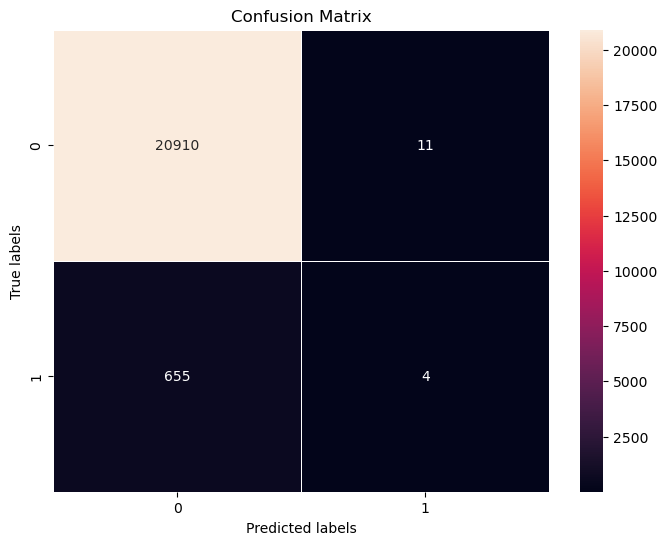

In [44]:
# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Verdaderos Negativos (TN): 20,910

El modelo predijo correctamente la clase de no fraude en 20,910 casos.

Falsos Positivos (FP): 11

El modelo predijo incorrectamente que 11 transacciones no fraudulentas eran fraudulentas.

Falsos Negativos (FN): 655

El modelo no detectó 655 transacciones fraudulentas, clasificándolas erróneamente como no fraudulentas.

Verdaderos Positivos (VP): 4

Solo 4 transacciones fraudulentas fueron correctamente identificadas como tales.


Con estos resultados observamos que el modelo no esta siendo favorable y debemos corregir el desbalance 

### Balanceo de Clases

Con el parametro *class_weight='balanced* trato de ajustar los pesos de las clases, entrenando al modelo ponderado en el conjunto de datos de entrenamiento. 

In [45]:
# Modelo con ponderación de clases
logistic_model_balanced = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model_balanced.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [46]:
# Predecir en el conjunto de prueba
y_pred = logistic_model_balanced.predict(X_test)

In [47]:
# Evaluar el modelo
evaluation_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

evaluation_report, conf_matrix

('              precision    recall  f1-score   support\n\n           0       0.99      0.71      0.83      5244\n           1       0.06      0.63      0.11       151\n\n    accuracy                           0.71      5395\n   macro avg       0.52      0.67      0.47      5395\nweighted avg       0.96      0.71      0.81      5395\n',
 array([[3736, 1508],
        [  56,   95]], dtype=int64))

In [48]:
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      5244
           1       0.06      0.63      0.11       151

    accuracy                           0.71      5395
   macro avg       0.52      0.67      0.47      5395
weighted avg       0.96      0.71      0.81      5395



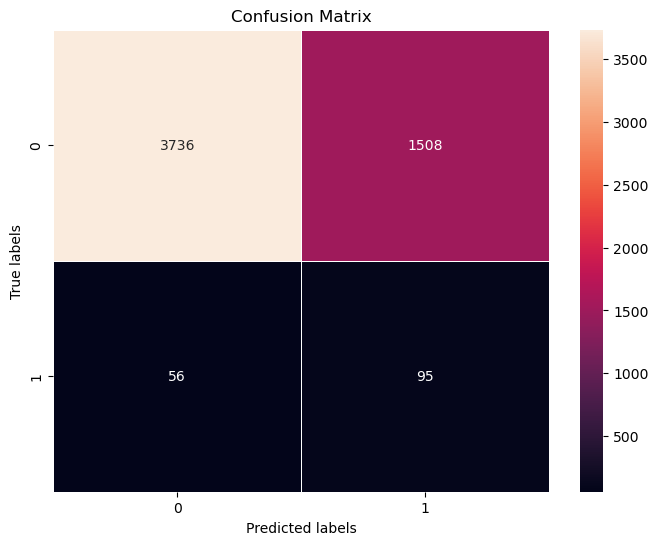

In [49]:
# Obtener predicciones mediante validación cruzada
y_pred_bal = cross_val_predict(logistic_model_balanced, X_train, y_train, cv=5)
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Conclusión de balanceo

Desbalance en el Recall: Aunque el modelo tiene una alta tasa de detección de fraudes (recall para la clase 1), también tiene un alto porcentaje de falsos positivos (baja precisión para la clase 1).

#### Matriz de Confusión

Verdaderos Negativos (3734): Número de no fraudes correctamente identificados.

Falsos Positivos (1510): Número de no fraudes incorrectamente identificados como fraude.

Falsos Negativos (55): Número de fraudes que no se detectaron.

Verdaderos Positivos (96): Número de fraudes correctamente identificados.

### Aplicamos técnica SMOTE (Synthetic Minority Over-sampling Technique)

El objetivo es resolver el desbalance que hemos estado viendo, atacando la clase menor


In [50]:
from imblearn.over_sampling import SMOTE


In [51]:
# inicia SMOTE
smote = SMOTE(random_state=42)

In [52]:
# aplicamos SMOTE al conjunto train
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [53]:
# nueva distribución de clases
class_distribution_smote = pd.Series(y_train_smote).value_counts()

In [54]:
# Entrenar el modelo con SMOTE
logistic_model_smote = LogisticRegression(random_state=42)
logistic_model_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(random_state=42)

In [55]:
# predecir en conjunto de prueba
y_pred_smote = logistic_model_smote.predict(X_test)

In [56]:
# Evaluar SMOTE
evaluation_report_smote = classification_report(y_test, y_pred_smote)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)

In [57]:
class_distribution_smote, evaluation_report_smote, conf_matrix_smote

(0    20921
 1    20921
 Name: fraude, dtype: int64,
 '              precision    recall  f1-score   support\n\n           0       0.99      0.71      0.82      5244\n           1       0.06      0.64      0.11       151\n\n    accuracy                           0.70      5395\n   macro avg       0.52      0.67      0.46      5395\nweighted avg       0.96      0.70      0.80      5395\n',
 array([[3702, 1542],
        [  55,   96]], dtype=int64))

In [58]:
# Valido distribusión 
print(class_distribution_smote)

0    20921
1    20921
Name: fraude, dtype: int64


In [59]:
# Resultado SMOTE
print(evaluation_report_smote)

              precision    recall  f1-score   support

           0       0.99      0.71      0.82      5244
           1       0.06      0.64      0.11       151

    accuracy                           0.70      5395
   macro avg       0.52      0.67      0.46      5395
weighted avg       0.96      0.70      0.80      5395



In [60]:
print(conf_matrix_smote)

[[3702 1542]
 [  55   96]]


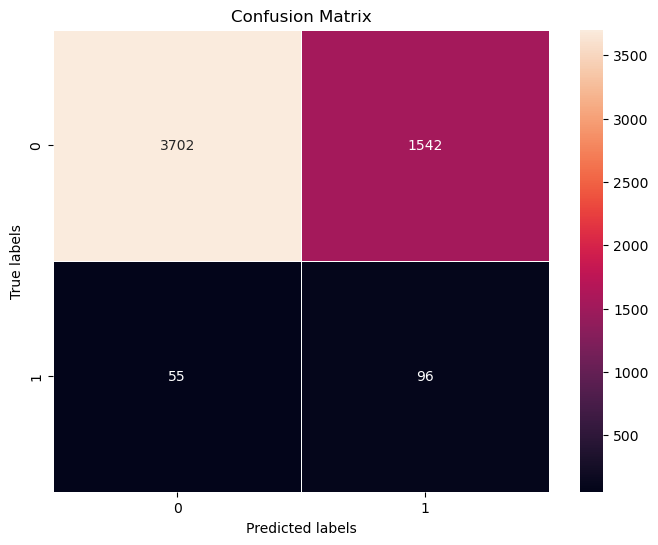

In [61]:
# Obtener predicciones mediante validación cruzada
y_pred_bal = cross_val_predict(logistic_model_smote, X_train, y_train, cv=5)
cm = confusion_matrix(y_test, y_pred_smote)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Conclusiones al usar SMOTE

##### Clase 0 (No Fraude)

Precisión: Alta (99%), lo que significa que cuando el modelo predice que una transacción no es fraude, casi siempre es correcto.

Recall del 70% las no fraudulentas se están clasificando erróneamente como fraudulentas falsos positivos.

F1-Score: Moderado (0.82), reflejando el desequilibrio entre precisión y recall.

##### Clase 1 (Fraude)

Precisión: Baja (6%), lo que implica que de todas las transacciones que el modelo identifica como fraudulentas, solo un pequeño porcentaje lo son realmente.

**Recall: Alto (63%)**, lo cual es positivo ya que muestra que el modelo puede identificar una gran proporción de todas las cuentas fraudulentas reales.

F1-Score: Bajo (0.11), afectado por la baja precisión.

#### Precision-Recall para SMOTE

Las métricas de rendimiento no siempre capturan completamente la calidad del modelo, especialmente en conjuntos de datos desequilibrados. calculamos la curva ROC (Receiver Operating Characteristic) y el área bajo la curva (AUC) para obtener una medida más clara de la capacidad del modelo para distinguir entre las clases.

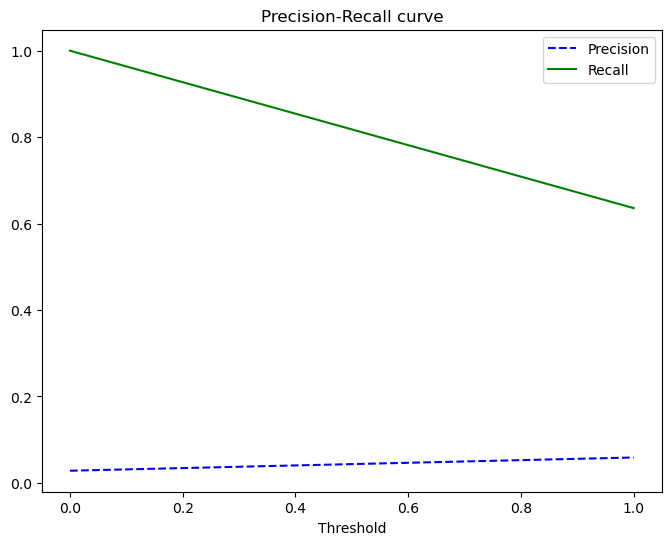

In [62]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_smote)

# Graficar la curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel('Threshold')
plt.title('Precision-Recall curve')
plt.legend(loc="best")
plt.show()

Con este grafico se intenta observas la curva de precisión y recall donde vemos que cambian a medida que ajustamos el umbral para la clasificación de una clase minorista

### Otra técnica que usaré es "logistic_model_weighted"

trato de resolver el desequilibrio de clases usando el conjunto de entrenamiento, haciendo una ponderación de clases. El objetivo es ajustar los pesos de las clases al entrenar el modelo.

In [63]:
# inicio de weighted
logistic_model_weighted = LogisticRegression(class_weight='balanced', random_state=42)
logistic_model_weighted.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [64]:
# predecir en el modelo de prueba 
y_pred_weighted = logistic_model_weighted.predict(X_test)

In [65]:
# evaluar weighted
evaluation_report_weighted = classification_report(y_test, y_pred_weighted)
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)

evaluation_report_weighted, conf_matrix_weighted

('              precision    recall  f1-score   support\n\n           0       0.99      0.71      0.83      5244\n           1       0.06      0.63      0.11       151\n\n    accuracy                           0.71      5395\n   macro avg       0.52      0.67      0.47      5395\nweighted avg       0.96      0.71      0.81      5395\n',
 array([[3736, 1508],
        [  56,   95]], dtype=int64))

In [66]:
print(evaluation_report_weighted)

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      5244
           1       0.06      0.63      0.11       151

    accuracy                           0.71      5395
   macro avg       0.52      0.67      0.47      5395
weighted avg       0.96      0.71      0.81      5395



In [67]:
print(conf_matrix_weighted)

[[3736 1508]
 [  56   95]]


#### Informe de Evaluación

- Precisión para no fraudulentos del 99% alto para los no fraudulentas

- Recall para no fraudulentos: 71% (falsos positivos)

- F1-score para no fraudulentos: 83%


- Precisión para fraudulentos del 6% aún que es bajo identifica correctamente algunas transacciones fraudulentas

- Recall para fraudulentos: 63% una mejora significancia, el modelo ahora es capaz de identificar más fraudes

- F1-score para fraudulentos: 11%


#### Matriz de Confusión: 
Una representación gráfica que ayuda a visualizar el desempeño del modelo en términos de falsos positivos, falsos negativos, verdaderos positivos y verdaderos negativos.

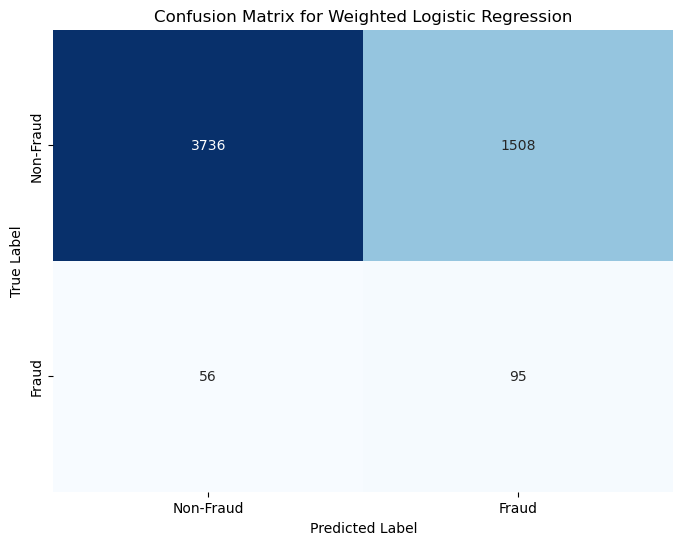

In [68]:
# matriz confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_weighted, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Weighted Logistic Regression')
plt.show()


#### Matriz de Confusión

- Verdaderos Negativos (TN): 3738
- Falsos Positivos (FP): 1506 transacciones no fraudulentas identificadas erróneamente como fraudulentas
- Verdaderos Positivos (VP): 95 transacciones fraudulentas identificadas correctamente
- Falsos Negativos (FN): 56 transacciones fraudulentas no detectadas

### Reporte de Clasificación:
Una tabla que muestre las métricas clave (precisión, recall, f1-score) para cada clase, nos ayuda a entender mucho mejor los resultados

In [69]:
# informe de clasificación

report_df = pd.DataFrame(classification_report(y_test, y_pred_weighted, output_dict=True)).T
display(report_df)



,precision,recall,f1-score,support
0,0.985232,0.712433,0.826915,5244.000000
1,0.059264,0.629139,0.108324,151.000000
accuracy,0.710102,0.710102,0.710102,0.710102
macro avg,0.522248,0.670786,0.467619,5395.000000
weighted avg,0.959315,0.710102,0.806802,5395.000000


#### Curva ROC:
Un gráfico que muestra la relación entre la tasa de verdaderos positivos y la tasa de falsos positivos a diferentes umbrales de clasificación. Esto es útil para evaluar la capacidad discriminativa del modelo.

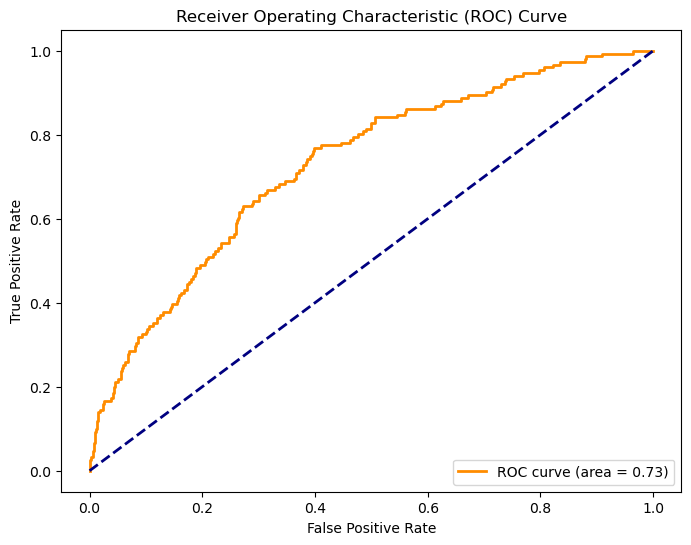

In [70]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logistic_model_weighted.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Conclusiones finales

Este modelo muestra una mejora considerablemente en la detección de transacciones fraudulentas a expensas de un mayor número de falsos positivos, lo que afecta la precisión y el recall de la clase 0. 

Podemos observas el grafico un AUC del 73% lo que nos dice que si bien no es el mejor modelo tiene la capacidad de distinguir relativamente bien entre la clase positiva y negativa. Mientras que la cuerva ROC esta por encima de la línea de clasificación aleatoria.

#### Recomendaciones adicionales:

Exploración de Umbrales: si bien ya hemos exploraro varias formas formas para atacar el desequilibrio podemos evaluar diferentes umbrales de decisión para encontrar un punto óptimo que mejore la precisión sin comprometer demasiado el recall, potencialmente utilizando la curva de precisión-recuerdo además de la curva ROC.